In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import make_interp_spline
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
def model(x, weight, const):
    return x @ weight + const

def mean_sq_avg(t1, t2):
    diff = t1-t2
    diff = diff**2
    return torch.sum(diff)/diff.numel()

def sorting(x, y):
    j=1
    for i in range(0, x.size):
        while j<x.size:
            if x[i]>x[j]:
                temp=y[i]
                y[i]=y[j]
                y[j]=temp
            j=j+1
    return y

In [4]:
# Input (temp, rainfall, humidity)

inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Target (aplles, oranges)

target = np.array([[56, 70],
                   [81, 101],
                   [119, 133],
                   [22, 37],
                   [103, 119]], dtype='float32')

inputs = torch.from_numpy(inputs)
target = torch.from_numpy(target)

 yield apple = w11.T + w12.R + w13.H + b1
 yield orange = w21.T + w22.R + w23.H + b2
 here we can see that (w1, w2, w3) form a matrix W, (T, R, H) from a matrix X and b1 forms a vector b
 we can write each eqn as Y = X x W + b

In [5]:
w = torch.randn(3, 2, requires_grad=True)
b = torch.randn(2, requires_grad=True)

print("w=")
print(w)
print("b=")
print(b)
prediction = model(inputs, w, b)
print("prediction= ", prediction)

w=
tensor([[ 0.3357,  2.0423],
        [ 0.8007, -1.0167],
        [ 1.7232, -0.1863]], requires_grad=True)
b=
tensor([-1.1008, -1.4984], requires_grad=True)
prediction=  tensor([[151.1454,  71.4557],
        [210.1885,  82.9525],
        [235.3365,  29.1309],
        [131.3258, 156.2025],
        [219.5476,  28.7697]], grad_fn=<AddBackward0>)


we can see that our prediction matrix is completly unequal to the target matrix. this is because we have used random values of w and b. therefore we need to make a loss function first we will make a difference matrix of target and predicted matrices. to remove the negative values we will square the matrix and then find the mean sqr avg value of the elements
    then the avg diff will be the sqrt of the mean sqr avg value this avg diff is called the loss and lower if the loss lower is the lower is the loss of data.

In [6]:
loss = mean_sq_avg(target, prediction)
print("loss= ", loss)
loss.backward()

loss=  tensor(9827.9355, grad_fn=<DivBackward0>)


In [7]:
# now we will find the loss w.r.t each Wij
# therfore we need to take the derivative of the loss wrt to each Wij

loss_wrt_w = w.grad
loss_wrt_b = b.grad
print("loss_wrt_w= ")
print(loss_wrt_w)
print("loss_wrt_b= ")
print(loss_wrt_b)

loss_wrt_w= 
tensor([[ 9603.2139,  -927.9810],
        [ 9844.4004, -3789.1021],
        [ 6262.0449, -1804.4966]])
loss_wrt_b= 
tensor([113.3088, -18.2977])


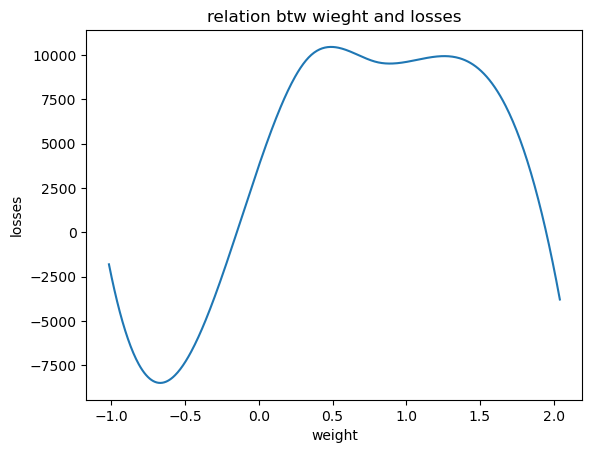

In [8]:
# ploting curve between num1 and num2

num1 = w.detach().numpy()
num2 = loss_wrt_w.detach().numpy()
num1 = num1.flatten()
num2 = num2.flatten()
num2 = sorting(num1, num2)
num1.sort()
X_Y_Spline = make_interp_spline(num1, num2)
X_ = np.linspace(num1.min(), num1.max(), 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_, Y_)
plt.title("relation btw wieght and losses")
plt.xlabel("weight")
plt.ylabel("losses")
plt.show()

if we look into the graph, the wieghts have a local minima near them. so to  minimize the losses we will have to shift the weight to the neighbour of the local minima. therefore we will have to subtract a small proportion of the gradient from the wieght matrix

In [9]:
with torch.no_grad():
    w-=loss_wrt_w * 1e-5
    b-=loss_wrt_b * 1e-5
    w.grad.zero_()
    b.grad.zero_()

print("updated w=")
print(w)
print("updated b= ")
print(b)

prediction = model(inputs, w, b)
loss = mean_sq_avg(target, prediction)
print("new loss= ", loss)

updated w=
tensor([[ 0.2397,  2.0516],
        [ 0.7022, -0.9789],
        [ 1.6606, -0.1683]], requires_grad=True)
updated b= 
tensor([-1.1019, -1.4983], requires_grad=True)
new loss=  tensor(7577.3516, grad_fn=<DivBackward0>)


In [10]:
# now we will try to reduce the loss as much as possible. therefore we will continuosly
# improve the w matrix. these iterations are called *epochs*

while(True):
    loss.backward()
    loss_wrt_w = w.grad
    loss_wrt_b = b.grad
    with torch.no_grad():
        w-=loss_wrt_w * 1e-5
        b-=loss_wrt_b * 1e-5
        w.grad.zero_()
        b.grad.zero_()
    prediction = model(inputs, w, b)
    loss = mean_sq_avg(target, prediction)
    #print("new loss= ", loss)
    if loss<1.01:
        break

print("new w=")
print(w)
print("new b=")
print(b)
print("new loss=")
print(loss)
print("prediction")
print(prediction)
print("target")
print(target)

new w=
tensor([[-0.4072, -0.2736],
        [ 0.8222,  0.8221],
        [ 0.7597,  0.8495]], requires_grad=True)
new b=
tensor([-1.1129, -1.5100], requires_grad=True)
new loss=
tensor(1.0096, grad_fn=<DivBackward0>)
prediction
tensor([[ 56.9205,  70.1196],
        [ 82.8124, 100.2963],
        [117.7057, 134.1086],
        [ 20.8200,  37.3578],
        [102.9069, 117.9897]], grad_fn=<AddBackward0>)
target
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [11]:
# now we will work on a bigger data set

inputs = np.array([[73,67,43],[91,88,64],[87,134,58],
                  [102,43,37],[69,96,70],[73,67,43],
                  [91,88,64],[87,134,58],[102,43,37],
                  [69,96,70],[73,67,43],[91,88,64],
                  [87,134,58],[102,43,37],[69,96,70]], dtype = "float32")

target = np.array([[56, 70],[81, 101],[119, 133],
                   [22, 37],[103, 119],[56, 70],
                   [81, 101],[119, 133],[22, 37],
                   [103, 119],[56, 70],[81, 101],
                   [119, 133],[22, 37],[103, 119]], dtype = "float32")

inputs = torch.from_numpy(inputs)
target = torch.from_numpy(target)

# DATASET and DATALOADER

we'll create a TensorDataSet, which allows access to rows from inputs an target as tuples and provide standard API's for working with many different types of datasets in pytorch

the TensorDataSet allows us to access a small section od the training data using the array indexing notation. It returns a tuple in which the first element contains the input variables for the selected rows and the second contains the target

We will also create a DataLoader, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data 

In [12]:
train_ds = TensorDataset(inputs, target)
print(train_ds[:])
print(train_ds[[1,3,5,7]])

(tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]]), tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]]))
(tensor([[ 91.,  88.,  64.],
        [102.,  43.,  37.],
        [ 73.,  67.,  43.],
        [ 87., 134.,  58.]]), tensor([[ 81., 101.],
        [ 22.,  37.],
        [ 56.,  70.],
        [119., 133.]]))


In [13]:
train_dl = DataLoader(train_ds, 5, shuffle=True)
for xb, yb in train_dl:
    print(xb)
    print(yb)

tensor([[ 73.,  67.,  43.],
        [ 69.,  96.,  70.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [103., 119.],
        [ 81., 101.],
        [119., 133.],
        [103., 119.]])
tensor([[ 87., 134.,  58.],
        [102.,  43.,  37.],
        [102.,  43.,  37.],
        [102.,  43.,  37.],
        [ 91.,  88.,  64.]])
tensor([[119., 133.],
        [ 22.,  37.],
        [ 22.,  37.],
        [ 22.,  37.],
        [ 81., 101.]])
tensor([[ 73.,  67.,  43.],
        [ 73.,  67.,  43.],
        [ 87., 134.,  58.],
        [ 91.,  88.,  64.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 56.,  70.],
        [119., 133.],
        [ 81., 101.],
        [103., 119.]])


# nn.Linear
#### Instead of initializing the weigths & biases manually, we can define the model using the nn.Linear class from the PyTorch, which does it automatically

In [14]:
# define model

mod = nn.Linear(3,2)
# 3 because we have 3 columns in weight matrix
# 2 because we have 2 columns in b matrix
print(mod.weight)
print(mod.bias)

Parameter containing:
tensor([[ 0.0705, -0.4928, -0.1836],
        [ 0.0575,  0.0426,  0.2391]], requires_grad=True)
Parameter containing:
tensor([-0.0173, -0.0282], requires_grad=True)


In [15]:
preds = mod(inputs)
print(preds)
t = list(mod.parameters())
# preds = model(inputs, mod.weight.t(), mod.bias)
# print(preds)

tensor([[-35.7836,  17.2976],
        [-48.7195,  24.2458],
        [-70.5704,  24.5390],
        [-20.8081,  16.5087],
        [-55.3158,  24.7561],
        [-35.7836,  17.2976],
        [-48.7195,  24.2458],
        [-70.5704,  24.5390],
        [-20.8081,  16.5087],
        [-55.3158,  24.7561],
        [-35.7836,  17.2976],
        [-48.7195,  24.2458],
        [-70.5704,  24.5390],
        [-20.8081,  16.5087],
        [-55.3158,  24.7561]], grad_fn=<AddmmBackward0>)


# Loss Function
#### Instead of definging a loss function manually, we can use the built-in loss function mse_loss

In [16]:
# define a loss function
loss_fn = F.mse_loss
loss = loss_fn(mod(inputs), target)
print(loss)

tensor(11781.9062, grad_fn=<MseLossBackward0>)


# Optimizer
#### Instead of manully manipulating the models weight & biases using gradients, we can use the optimizer optim.SGD. SGD stands for stochastic gradient descent. It is called stochastic because samples are selected in batches  instead of as a single group

In [17]:
# define optimizer
opt = torch.optim.SGD(mod.parameters(), lr=1e-5)

# lr stands for the learning rate which we can specify

# Train the model

### we are now ready to train the model. 

#### 1. Generate predictions
#### 2. calculate the loss
#### 3. compute gradients wrt weights and biases
#### 4. adjust the weight by subtracting a small quantity propotional to the gradient 
#### 5. Reset the gradient to zero

##### The only change i sthat we'll work batches of data instead of processing the entire training data in every iteration. Let's define a utility function fit which trains the model for a given number of epoches

In [18]:
# Utility function
def fit(num_epochs, model, loss_fn, opt):
    for i in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()  # update parameters using gardients
            opt.zero_grad()
        if (i+1)%10 == 0:
            print("Epoch [{}/{}], loss: {:.4f}".format(i+1, num_epochs, loss.item()))
            # .item() gives the numerical value out of it, since the loss function is a tensor

fit(300, mod, loss_fn, opt)

Epoch [10/300], loss: 187.1960
Epoch [20/300], loss: 40.1257
Epoch [30/300], loss: 383.2818
Epoch [40/300], loss: 63.6820
Epoch [50/300], loss: 83.0364
Epoch [60/300], loss: 67.0860
Epoch [70/300], loss: 80.2449
Epoch [80/300], loss: 44.7862
Epoch [90/300], loss: 48.1691
Epoch [100/300], loss: 30.6769
Epoch [110/300], loss: 20.0414
Epoch [120/300], loss: 16.1089
Epoch [130/300], loss: 7.2776
Epoch [140/300], loss: 8.8952
Epoch [150/300], loss: 11.5194
Epoch [160/300], loss: 7.4423
Epoch [170/300], loss: 12.2119
Epoch [180/300], loss: 7.5030
Epoch [190/300], loss: 10.1707
Epoch [200/300], loss: 4.0217
Epoch [210/300], loss: 8.0456
Epoch [220/300], loss: 8.4909
Epoch [230/300], loss: 7.5193
Epoch [240/300], loss: 7.4864
Epoch [250/300], loss: 4.4625
Epoch [260/300], loss: 6.4591
Epoch [270/300], loss: 6.6691
Epoch [280/300], loss: 3.8158
Epoch [290/300], loss: 6.4389
Epoch [300/300], loss: 3.4629


In [19]:
pred = mod(inputs)
print(pred)

tensor([[ 57.3285,  70.4716],
        [ 81.0217,  99.4752],
        [121.0638, 135.4166],
        [ 21.9661,  37.8543],
        [ 99.3435, 116.5637],
        [ 57.3285,  70.4716],
        [ 81.0217,  99.4752],
        [121.0638, 135.4166],
        [ 21.9661,  37.8543],
        [ 99.3435, 116.5637],
        [ 57.3285,  70.4716],
        [ 81.0217,  99.4752],
        [121.0638, 135.4166],
        [ 21.9661,  37.8543],
        [ 99.3435, 116.5637]], grad_fn=<AddmmBackward0>)


In [20]:
print(target)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [23]:
print(mod.weight)
print(mod.bias)

Parameter containing:
tensor([[-0.3587,  0.9081,  0.5276],
        [-0.2612,  0.8563,  0.7487]], requires_grad=True)
Parameter containing:
tensor([-0.0164, -0.0276], requires_grad=True)


In [24]:
w = mod.weight
b = mod.bias
w11, w12, w13 = w[0,0], w[0,1], w[0,2]
w21, w22, w23 = w[1,0], w[1,1], w[1,2]
b1, b2 = b[0], b[1]

In [26]:
temp = float(input("temp: "))
humi = float(input("humidity: "))
rain = float(input("rainfall: "))
orange = w11*temp + w12*humi + w13*rain + b2
apple = w21*temp + w22*humi + w23*rain + b1
if apple>orange:
    print("Apple production will be more!")
elif orange>apple:
    print("Orange production will be more!")
else:
    print("Both will have the same production!")

temp: 50
humidity: 30
rainfall: 60
Apple production will be more!


# Just for fun

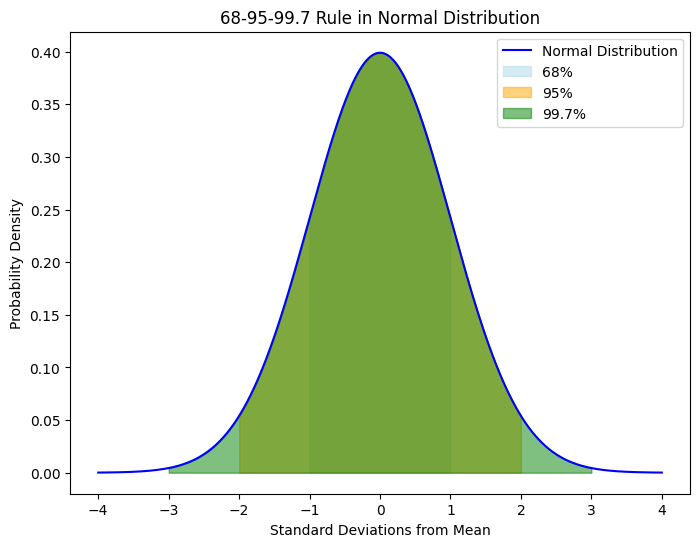

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate data for a normal distribution
mean = 0
std_dev = 1
x = np.linspace(-4*std_dev, 4*std_dev, 1000)
y = stats.norm.pdf(x, mean, std_dev)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, color='blue', label='Normal Distribution')

# Shade the areas under the curve
ax.fill_between(x, y, where=(x >= mean - std_dev) & (x <= mean + std_dev), color='lightblue', alpha=0.5, label='68%')
ax.fill_between(x, y, where=(x >= mean - 2*std_dev) & (x <= mean + 2*std_dev), color='orange', alpha=0.5, label='95%')
ax.fill_between(x, y, where=(x >= mean - 3*std_dev) & (x <= mean + 3*std_dev), color='green', alpha=0.5, label='99.7%')

# Add labels and legend
ax.set_title('68-95-99.7 Rule in Normal Distribution')
ax.set_xlabel('Standard Deviations from Mean')
ax.set_ylabel('Probability Density')
ax.legend()

plt.show()


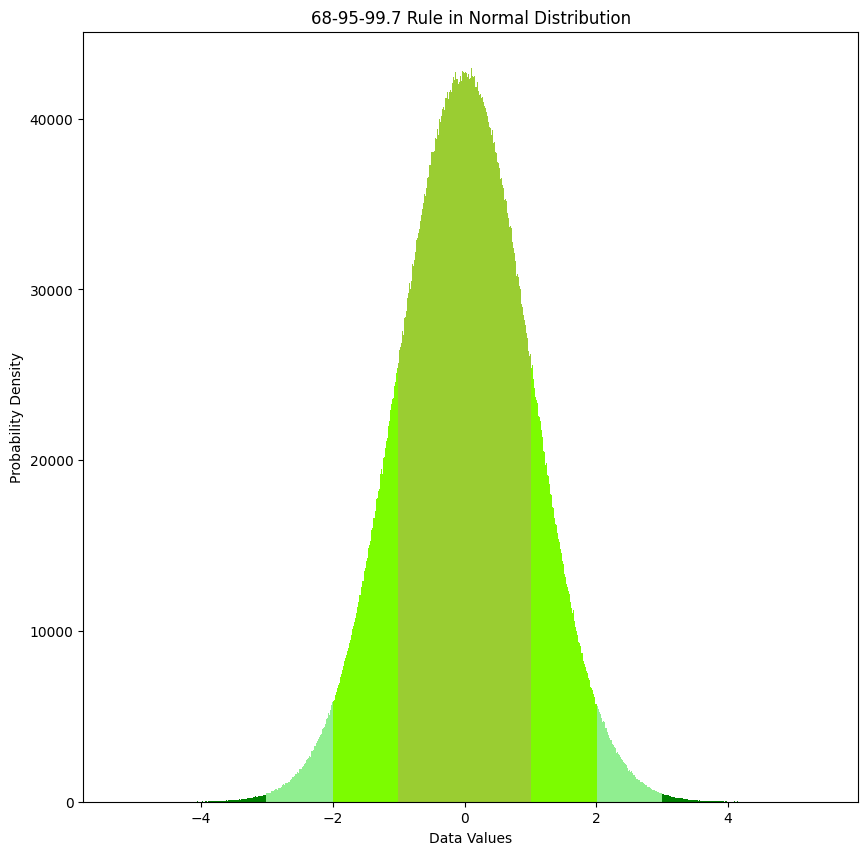

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data from a standard normal distribution
data = np.random.randn(10000000)  # 1Cr data points

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the histogram
n, bins, patches = ax.hist(data, bins=1000, color='blue', label='Histogram')

# Identify the bins within the range -1 to 1
for patch, bin_left, bin_right in zip(patches, bins[:-1], bins[1:]):
    if -1 <= bin_left <= 1 or -1 <= bin_right <= 1:
        patch.set_facecolor('yellowgreen')  # Set the color for bins within the range -1 to 1
    elif -2 <= bin_left <= 2 or -2 <= bin_right <= 2:
        patch.set_facecolor('lawngreen')
    elif -3 <= bin_left <= 3 or -3 <= bin_right <= 3:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('green')   # Set the default color for other bins

# Add labels and legend
ax.set_title('68-95-99.7 Rule in Normal Distribution')
ax.set_xlabel('Data Values')
ax.set_ylabel('Probability Density')

plt.show()